In [ ]:
import pandas as pd 
import random
import regex
import math
from collections import namedtuple
from datetime import date, datetime, timedelta
import os

timeslot = namedtuple('Interval', ['start', 'end'])

In [ ]:
INPUT_FOLDER = 'inputs'

CSV_INPUT_PATH = os.path.join(INPUT_FOLDER,"Test_log.csv") # path to input excel file
CALENDAR_CSV_PATH = os.path.join(INPUT_FOLDER,"CalendarMeets_Last.csv")
GOOGLE_MEET_EXCEL_PATH = os.path.join(INPUT_FOLDER,"meetlogs.xlsx")

In [ ]:
def is_mentor(email):
    if pd.isnull(email):
        return True
    domain = email[email.index('@') + 1 : ]
    if (domain == "villagebookbuilders.org" and email != "brett@villagebookbuilders.org") or email == "mpmukono@villagementors.org": # is a mentee; Brett and mpmukono are special cases (a mentor and mentee email, respectively)
        return False
    else:
        return True # default to assuming a user is a mentor
    
    
def merge_times(times): # merge mentors or mentees if more than one of each is present in a meeting at the same time
    times.sort()
    for i in range(len(times) - 1):
        first_end = times[i][1]
        next_start = times[i + 1][0]

        if first_end.time() > next_start.time():
            new_start = min(times[i].start, times[i+1].start)
            new_end = max(times[i].end, times[i+1].end)

            new_slot = timeslot(new_start, new_end)
            first_time = times[i]
            next_time = times[i+1]
            times.remove(first_time)
            times.remove(next_time)
            times.append(new_slot)
            break
            merge_times(times)
    return times


def get_overlap(first, second): # returns whatever overlap may exist between meetings
    return max(0, (min(first[1], second[1]) - max(first[0], second[0])).total_seconds())

In [ ]:
class MeetCleaner():
    def __init__(self):
        self.INPUT_PATH = "Test_log.csv" # path to input excel file
        self.df = self.load_csv(self.INPUT_PATH)
        
    def load_csv(self, path):
        return pd.read_csv(path)   
    
    def load_excel(self, path):
        return pd.read_excel(path)
    
    

In [ ]:
df = pd.read_csv(CSV_INPUT_PATH)
df.head(20)

,UTC,Meeting Code,Participant Identifier,Participant Name,Duration,IP Address,City,Country,startDateTime,endDateTime,Call Rating out of 5,Estimated Upload Bandwidth in kbps,Estimated Download Bandwidth in kbps,Audio Receive Duration,Audio Send Duration,Screencast Receive Duration,Screencast Send Duration,Video Receive Duration,Video Send Duration
0,2021-03-01T00:22:58,KBXMXJJDGG,maragoli2@villagebookbuilders.org,"Computer 2 Maragoli, Kenya",35,105.161.225.153,Nairobi,KE,2021-02-08T07:00:00-05:00,2021-02-08T08:00:00-05:00,NaN,261.0,9.0,23,23,0,0,13,23
1,2021-03-01T00:34:09,KBXMXJJDGG,vidhivbb@gmail.com,Vidhi Sapru,1924,NaN,NaN,NaN,2021-02-08T07:00:00-05:00,2021-02-08T08:00:00-05:00,NaN,894.0,8.0,61,1919,0,0,21,1919
2,2021-03-01T01:03:22,KBXMXJJDGG,vidhisapru@gmail.com,Vidhi Sapru,1731,NaN,NaN,NaN,2021-02-08T07:00:00-05:00,2021-02-08T08:00:00-05:00,NaN,923.0,153.0,974,974,0,657,843,974
3,2021-03-01T01:03:31,KBXMXJJDGG,maragoli2@villagebookbuilders.org,"Computer 2 Maragoli, Kenya",1756,105.161.225.153,Nairobi,KE,2021-02-08T07:00:00-05:00,2021-02-08T08:00:00-05:00,NaN,261.0,540.0,1694,1715,1341,0,840,1715
4,2021-03-02T03:50:54,RYQFAXYMHK,aisha.dhakal@villagementors.org,aisha dhakal,3166,24.4.192.102,Castro Valley,US,2021-02-23T10:00:00-05:00,2021-02-23T11:00:00-05:00,NaN,376.0,187.0,1777,3106,0,151,1777,2626
5,2021-03-02T03:50:57,RYQFAXYMHK,mpmaragoli@villagebookbuilders.org,Maragoli Kenya,1993,105.160.97.13,Nairobi,KE,2021-02-23T10:00:00-05:00,2021-02-23T11:00:00-05:00,NaN,420.0,457.0,1989,1999,796,0,1979,1999
6,2021-03-02T23:40:09,GFRDERDRUQ,maragoli4@villagebookbuilders.org,"Computer 4 Maragoli, Kenya",1036,105.161.226.33,Nairobi,KE,2021-03-03T10:00:00-05:00,2021-03-03T11:00:00-05:00,NaN,114.0,6.0,0,1035,0,0,0,1035
7,2021-03-03T03:03:16,AGNWJJQMZZ,julie.rochus1@villagementors.org,julie rochus,16,2806:10a6:5:f0d0:4505:bf1:ef84:aeae,Heroica Veracruz,MX,2021-03-03T10:00:00-05:00,2021-03-03T11:00:00-05:00,NaN,0.0,0.0,0,0,0,0,0,0
8,2021-03-03T03:21:12,GFRDERDRUQ,bmiyata888@gmail.com,Bianca Miyata,1671,NaN,NaN,NaN,2021-03-03T10:00:00-05:00,2021-03-03T11:00:00-05:00,NaN,143.0,6.0,0,1679,0,0,0,1679
9,2021-03-03T04:18:16,AGNWJJQMZZ,julie.rochus1@villagementors.org,julie rochus,4492,2806:10a6:5:f0d0:4505:bf1:ef84:aeae,Heroica Veracruz,MX,2021-03-03T10:00:00-05:00,2021-03-03T11:00:00-05:00,NaN,4.0,0.0,0,4492,0,0,0,0


In [ ]:
df = pd.read_csv(CSV_INPUT_PATH)

df['is_mentor'] = df['Participant Identifier'].apply(is_mentor)
df['UTC'] = pd.to_datetime(df['UTC']+'-'+df['startDateTime'].str.split('-', expand = True)[3], utc=True)
df['durationUTC'] = df.UTC - df.Duration * timedelta(seconds=1)

df['meetStartUTC'] = df['UTC'].dt.floor('H') #Based on UTC Column
df['meetEndUTC'] = df['UTC'].dt.ceil('H')

df['startDateTime'] = pd.to_datetime(df['startDateTime'], utc=True)
df['endDateTime'] = pd.to_datetime(df['endDateTime'], utc=True)

df['meetStartDuration'] = (df['durationUTC']-timedelta(minutes = 15)).dt.round('H')
df['meetEndDuration'] = df.durationUTC + (df.endDateTime - df.startDateTime)

df['deltaStart'] = df['startDateTime'] - df['meetStartDuration']
df['deltaEnd'] = df['endDateTime'] - df['meetEndDuration']

#df['deltaStart'] = df.UTC - df.Duration * timedelta(seconds=1) - df.startDateTime
#df['deltaEnd'] = df.UTC - df.endDateTime

In [ ]:
df[['UTC','durationUTC','Duration','meetStartDuration','deltaStart','meetEndDuration','meetStartUTC','meetEndUTC','startDateTime','endDateTime','deltaEnd']].head(20)

,UTC,durationUTC,Duration,meetStartDuration,deltaStart,meetEndDuration,meetStartUTC,meetEndUTC,startDateTime,endDateTime,deltaEnd
0,2021-03-01 05:22:58+00:00,2021-03-01 05:22:23+00:00,35,2021-03-01 05:00:00+00:00,-21 days +07:00:00,2021-03-01 06:22:23+00:00,2021-03-01 05:00:00+00:00,2021-03-01 06:00:00+00:00,2021-02-08 12:00:00+00:00,2021-02-08 13:00:00+00:00,-21 days +06:37:37
1,2021-03-01 05:34:09+00:00,2021-03-01 05:02:05+00:00,1924,2021-03-01 05:00:00+00:00,-21 days +07:00:00,2021-03-01 06:02:05+00:00,2021-03-01 05:00:00+00:00,2021-03-01 06:00:00+00:00,2021-02-08 12:00:00+00:00,2021-02-08 13:00:00+00:00,-21 days +06:57:55
2,2021-03-01 06:03:22+00:00,2021-03-01 05:34:31+00:00,1731,2021-03-01 05:00:00+00:00,-21 days +07:00:00,2021-03-01 06:34:31+00:00,2021-03-01 06:00:00+00:00,2021-03-01 07:00:00+00:00,2021-02-08 12:00:00+00:00,2021-02-08 13:00:00+00:00,-21 days +06:25:29
3,2021-03-01 06:03:31+00:00,2021-03-01 05:34:15+00:00,1756,2021-03-01 05:00:00+00:00,-21 days +07:00:00,2021-03-01 06:34:15+00:00,2021-03-01 06:00:00+00:00,2021-03-01 07:00:00+00:00,2021-02-08 12:00:00+00:00,2021-02-08 13:00:00+00:00,-21 days +06:25:45
4,2021-03-02 08:50:54+00:00,2021-03-02 07:58:08+00:00,3166,2021-03-02 08:00:00+00:00,-7 days +07:00:00,2021-03-02 08:58:08+00:00,2021-03-02 08:00:00+00:00,2021-03-02 09:00:00+00:00,2021-02-23 15:00:00+00:00,2021-02-23 16:00:00+00:00,-7 days +07:01:52
5,2021-03-02 08:50:57+00:00,2021-03-02 08:17:44+00:00,1993,2021-03-02 08:00:00+00:00,-7 days +07:00:00,2021-03-02 09:17:44+00:00,2021-03-02 08:00:00+00:00,2021-03-02 09:00:00+00:00,2021-02-23 15:00:00+00:00,2021-02-23 16:00:00+00:00,-7 days +06:42:16
6,2021-03-03 04:40:09+00:00,2021-03-03 04:22:53+00:00,1036,2021-03-03 04:00:00+00:00,0 days 11:00:00,2021-03-03 05:22:53+00:00,2021-03-03 04:00:00+00:00,2021-03-03 05:00:00+00:00,2021-03-03 15:00:00+00:00,2021-03-03 16:00:00+00:00,0 days 10:37:07
7,2021-03-03 08:03:16+00:00,2021-03-03 08:03:00+00:00,16,2021-03-03 08:00:00+00:00,0 days 07:00:00,2021-03-03 09:03:00+00:00,2021-03-03 08:00:00+00:00,2021-03-03 09:00:00+00:00,2021-03-03 15:00:00+00:00,2021-03-03 16:00:00+00:00,0 days 06:57:00
8,2021-03-03 08:21:12+00:00,2021-03-03 07:53:21+00:00,1671,2021-03-03 08:00:00+00:00,0 days 07:00:00,2021-03-03 08:53:21+00:00,2021-03-03 08:00:00+00:00,2021-03-03 09:00:00+00:00,2021-03-03 15:00:00+00:00,2021-03-03 16:00:00+00:00,0 days 07:06:39
9,2021-03-03 09:18:16+00:00,2021-03-03 08:03:24+00:00,4492,2021-03-03 08:00:00+00:00,0 days 07:00:00,2021-03-03 09:03:24+00:00,2021-03-03 09:00:00+00:00,2021-03-03 10:00:00+00:00,2021-03-03 15:00:00+00:00,2021-03-03 16:00:00+00:00,0 days 06:56:36


In [ ]:
#df[df.deltaStart.dt.days == 0][df.deltaStart.dt.seconds != 7*3600][['UTC','durationUTC','Duration','meetStartUTC','meetStartDuration','startDateTime','deltaStart','meetEndDuration','meetEndUTC','endDateTime','deltaEnd']]
df[df.deltaStart.dt.seconds != 7*3600][['UTC','durationUTC','Duration','meetStartUTC','meetStartDuration','startDateTime','deltaStart','meetEndDuration','meetEndUTC','endDateTime','deltaEnd']].head(20)

,UTC,durationUTC,Duration,meetStartUTC,meetStartDuration,startDateTime,deltaStart,meetEndDuration,meetEndUTC,endDateTime,deltaEnd
6,2021-03-03 04:40:09+00:00,2021-03-03 04:22:53+00:00,1036,2021-03-03 04:00:00+00:00,2021-03-03 04:00:00+00:00,2021-03-03 15:00:00+00:00,0 days 11:00:00,2021-03-03 05:22:53+00:00,2021-03-03 05:00:00+00:00,2021-03-03 16:00:00+00:00,0 days 10:37:07
11,2021-03-04 03:36:08+00:00,2021-03-04 03:33:55+00:00,133,2021-03-04 03:00:00+00:00,2021-03-04 03:00:00+00:00,2021-03-25 12:00:00+00:00,21 days 09:00:00,2021-03-04 04:33:55+00:00,2021-03-04 04:00:00+00:00,2021-03-25 13:00:00+00:00,21 days 08:26:05
14,2021-03-04 04:55:23+00:00,2021-03-04 04:50:43+00:00,280,2021-03-04 04:00:00+00:00,2021-03-04 05:00:00+00:00,2021-02-04 11:00:00+00:00,-28 days +06:00:00,2021-03-04 05:50:43+00:00,2021-03-04 05:00:00+00:00,2021-02-04 12:00:00+00:00,-28 days +06:09:17
15,2021-03-04 05:10:20+00:00,2021-03-04 04:53:23+00:00,1017,2021-03-04 05:00:00+00:00,2021-03-04 05:00:00+00:00,2021-02-25 11:00:00+00:00,-7 days +06:00:00,2021-03-04 05:53:23+00:00,2021-03-04 06:00:00+00:00,2021-02-25 12:00:00+00:00,-7 days +06:06:37
16,2021-03-04 04:10:32+00:00,2021-03-04 03:55:42+00:00,890,2021-03-04 04:00:00+00:00,2021-03-04 04:00:00+00:00,2021-03-25 12:00:00+00:00,21 days 08:00:00,2021-03-04 04:55:42+00:00,2021-03-04 05:00:00+00:00,2021-03-25 13:00:00+00:00,21 days 08:04:18
17,2021-03-04 04:10:46+00:00,2021-03-04 04:10:40+00:00,6,2021-03-04 04:00:00+00:00,2021-03-04 04:00:00+00:00,2021-03-25 12:00:00+00:00,21 days 08:00:00,2021-03-04 05:10:40+00:00,2021-03-04 05:00:00+00:00,2021-03-25 13:00:00+00:00,21 days 07:49:20
20,2021-03-04 06:10:46+00:00,2021-03-04 05:14:21+00:00,3385,2021-03-04 06:00:00+00:00,2021-03-04 05:00:00+00:00,2021-02-25 11:00:00+00:00,-7 days +06:00:00,2021-03-04 06:14:21+00:00,2021-03-04 07:00:00+00:00,2021-02-25 12:00:00+00:00,-7 days +05:45:39
28,2021-03-05 07:10:46+00:00,2021-03-05 07:08:44+00:00,122,2021-03-05 07:00:00+00:00,2021-03-05 07:00:00+00:00,2021-02-05 11:00:00+00:00,-28 days +04:00:00,2021-03-05 08:08:44+00:00,2021-03-05 08:00:00+00:00,2021-02-05 12:00:00+00:00,-28 days +03:51:16
29,2021-03-05 07:17:39+00:00,2021-03-05 07:13:52+00:00,227,2021-03-05 07:00:00+00:00,2021-03-05 07:00:00+00:00,2021-02-05 11:00:00+00:00,-28 days +04:00:00,2021-03-05 08:13:52+00:00,2021-03-05 08:00:00+00:00,2021-02-05 12:00:00+00:00,-28 days +03:46:08
31,2021-03-05 06:32:40+00:00,2021-03-05 06:06:25+00:00,1575,2021-03-05 06:00:00+00:00,2021-03-05 06:00:00+00:00,2021-03-19 14:00:00+00:00,14 days 08:00:00,2021-03-05 07:06:25+00:00,2021-03-05 07:00:00+00:00,2021-03-19 15:00:00+00:00,14 days 07:53:35


In [ ]:
df['cleanStartCalendar'] = df.startDateTime - df.deltaStart
df['cleanEndCalendar'] = df.endDateTime - df.deltaStart

df['meetingEnd'] = df.UTC
df['meetingStart'] = df.durationUTC

df['meetingDate'] = df['cleanStartCalendar'].dt.date

df['isMentor'] = df['Participant Identifier'].apply(is_mentor)

In [ ]:
clean_df = df[['Meeting Code','isMentor','meetingDate','meetingStart','meetingEnd','cleanStartCalendar','cleanEndCalendar', 'Duration']].copy()

In [ ]:
clean_df['puntctuality'] = (clean_df['meetingStart'] - clean_df['cleanStartCalendar']).dt.total_seconds()

In [ ]:
clean_df

,Meeting Code,isMentor,meetingDate,meetingStart,meetingEnd,cleanStartCalendar,cleanEndCalendar,Duration,puntctuality
0,KBXMXJJDGG,False,2021-03-01,2021-03-01 05:22:23+00:00,2021-03-01 05:22:58+00:00,2021-03-01 05:00:00+00:00,2021-03-01 06:00:00+00:00,35,1343.0
1,KBXMXJJDGG,True,2021-03-01,2021-03-01 05:02:05+00:00,2021-03-01 05:34:09+00:00,2021-03-01 05:00:00+00:00,2021-03-01 06:00:00+00:00,1924,125.0
2,KBXMXJJDGG,True,2021-03-01,2021-03-01 05:34:31+00:00,2021-03-01 06:03:22+00:00,2021-03-01 05:00:00+00:00,2021-03-01 06:00:00+00:00,1731,2071.0
3,KBXMXJJDGG,False,2021-03-01,2021-03-01 05:34:15+00:00,2021-03-01 06:03:31+00:00,2021-03-01 05:00:00+00:00,2021-03-01 06:00:00+00:00,1756,2055.0
4,RYQFAXYMHK,True,2021-03-02,2021-03-02 07:58:08+00:00,2021-03-02 08:50:54+00:00,2021-03-02 08:00:00+00:00,2021-03-02 09:00:00+00:00,3166,-112.0
...,...,...,...,...,...,...,...,...,...
307,VHEVHOMMZV,False,2021-03-28,2021-03-28 07:12:08+00:00,2021-03-28 08:01:03+00:00,2021-03-28 07:00:00+00:00,2021-03-28 08:00:00+00:00,2935,728.0
308,GARPQAOAHK,True,2021-03-29,2021-03-29 04:17:06+00:00,2021-03-29 05:03:16+00:00,2021-03-29 04:00:00+00:00,2021-03-29 05:00:00+00:00,2770,1026.0
309,DHHRIWPWFN,True,2021-03-31,2021-03-31 03:02:40+00:00,2021-03-31 03:20:57+00:00,2021-03-31 03:00:00+00:00,2021-03-31 04:00:00+00:00,1097,160.0
310,UKXBXWBXDM,True,2021-03-31,2021-03-31 06:19:21+00:00,2021-03-31 06:19:29+00:00,2021-03-31 06:00:00+00:00,2021-03-31 07:00:00+00:00,8,1161.0


<AxesSubplot:>

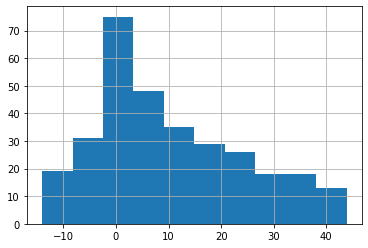

In [ ]:
(clean_df['puntctuality'].dt.total_seconds() / 60).hist()

<AxesSubplot:>

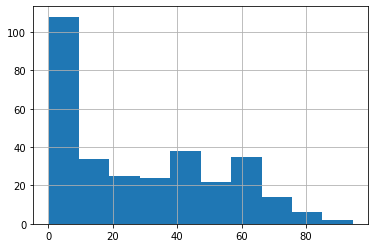

In [ ]:
(clean_df[clean_df['Duration'] <= 7200]['Duration']/60).hist()

In [ ]:
df4 = (clean_df.groupby(['Meeting Code','isMentor','meetingDate']).sum())

<AxesSubplot:>

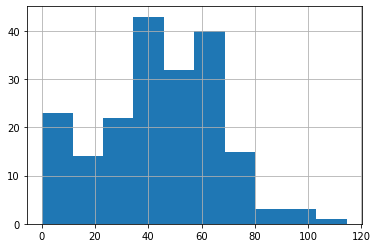

In [ ]:
(df4[df4['Duration'] <= 7200]['Duration']/60).hist()

### PROOF

In [ ]:
dfDelta = pd.DataFrame([df.deltaStart.dt.days,df.deltaStart.dt.seconds / 3600]).T
dfDelta.columns = ['days','hours']
dfDelta

,days,hours
0,-21.0,7.0
1,-21.0,7.0
2,-21.0,7.0
3,-21.0,7.0
4,-7.0,7.0
...,...,...
307,-49.0,7.0
308,-49.0,7.0
309,0.0,7.0
310,-21.0,7.0


In [ ]:
print(dfDelta.pivot_table(columns=['hours'], aggfunc='size'))

hours
4.0       2
6.0      21
7.0     244
8.0      36
9.0       5
10.0      2
11.0      1
12.0      1
dtype: int64


In [ ]:
(244+21+36)/312

0.9647435897435898

In [ ]:
print(dfDelta.pivot_table(columns=['days'], aggfunc='size'))

days
-49.0    28
-42.0    62
-35.0    23
-31.0     1
-28.0    62
-21.0    35
-14.0    14
-7.0     24
 0.0     43
 3.0      1
 7.0      5
 14.0     7
 21.0     7
dtype: int64
